In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy import stats
from gplearn import genetic
from gplearn.functions import make_function
from gplearn.genetic import SymbolicTransformer, SymbolicRegressor
from gplearn.fitness import make_fitness
from sklearn.linear_model import LinearRegression

# Preprocssing Process

In [2]:
etf_data = pd.read_csv('5500_dataset2.csv')
etf_data['Date'] = etf_data['Year'].astype(str) + '-' + etf_data['Month'].astype(str)
etf_data['Date'] = pd.to_datetime(etf_data['Date'], format='%Y-%m')
etf_data.set_index('Date', inplace=True)
etf_data.drop(['Year', 'Month'], axis=1, inplace=True)
etf_data = etf_data.resample('M').last()
tickers = ['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV', 'XLY']
macro_vars = [col for col in etf_data.columns if col not in tickers]
etf_data[macro_vars] = etf_data[macro_vars]
etf_data_long = etf_data.reset_index().melt(id_vars=['Date'], value_vars=tickers,
                                            var_name='Tickers', value_name='Price')
macro_data = etf_data[macro_vars]
df = etf_data_long.merge(macro_data, left_on='Date', right_index=True)
df.set_index(['Tickers', 'Date'], inplace=True)
df.sort_index(level='Tickers', inplace=True)
df['Return'] = df['Price'].pct_change()
df = df.dropna()

/var/folders/55/ysck04bj54j_6bw0v46q2k600000gn/T/ipykernel_41055/1814971077.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Return'] = df['Price'].pct_change()


In [3]:
df

Price  Business Applications  Construction Spending  \
Tickers Date                                                               
XLB     2004-12-31   19.25                 193328                1037480   
        2005-01-31   18.66                 201725                1046082   
        2005-02-28   20.13                 204234                1066848   
        2005-03-31   19.60                 201630                1071745   
        2005-04-30   18.20                 204096                1081012   
...                    ...                    ...                    ...   
XLY     2024-04-30  174.88                 430762                2163179   
        2024-05-31  175.23                 423211                2168211   
        2024-06-30  182.02                 430692                2168990   
        2024-07-31  187.10                 421534                2162683   
        2024-08-31  186.73                 431928                2162683   

                    Durable Goods New Orders  International Trade_Exports  \
Tickers Date                                                                
XLB     2004-12-31                    193578                       102781   
        2005-01-31                    194875                       103206   
        2005-02-28                    196475                       104010   
        2005-03-31                    186608                       105098   
        2005-04-30                    194847                       107268   
...                                      ...                          ...   
XLY     2024-04-30                    282737                       262314   
        2024-05-31                    282987                       260790   
        2024-06-30                    263541                       265266   
        2024-07-31                    289587                       266603   
        2024-08-31                    289720                       266603   

                    International Trade_Imports  Manu Inventories  \
Tickers Date                                                        
XLB     2004-12-31                       157699            441222   
        2005-01-31                       159395            446240   
        2005-02-28                       162104            451361   
        2005-03-31                       158231            455394   
        2005-04-30                       164580            456990   
...                                         ...               ...   
XLY     2024-04-30                       337217            858304   
        2024-05-31                       336096            859416   
        2024-06-30                       338282            858851   
        2024-07-31                       345394            859422   
        2024-08-31                       345394            859422   

                    Manu New Orders  New Homes For Sale  New Homes Sold  ...  \
Tickers Date                                                             ...   
XLB     2004-12-31           373419                 422            1242  ...   
        2005-01-31           378937                 441            1203  ...   
        2005-02-28           381880                 446            1319  ...   
        2005-03-31           374642                 445            1328  ...   
        2005-04-30           385450                 445            1260  ...   
...                             ...                 ...             ...  ...   
XLY     2024-04-30           586114                 464             736  ...   
        2024-05-31           583300                 468             672  ...   
        2024-06-30           563972                 468             681  ...   
        2024-07-31           592140                 459             751  ...   
        2024-08-31           592140                 467             716  ...   

                    Monetary Base       M2  Unemp_Rate  Auto Sales  \
Tickers Date         

# Rolling Exposure

In [4]:
features = [col for col in df.columns if col not in ['Price', 'Return']]
X = df[features]
Y = df['Return']

for feature in features:
    if df[feature].dtype == 'object':
        df[feature] = df[feature].str.replace(',', '').astype(float)
        
# Prepare the output dataframe to store rolling exposures
rolling_exposure = pd.DataFrame(index=df.index, columns=features)

# Rolling window length (36 months)
window_length = 36

# Iterate through each ticker group to calculate rolling exposures
for ticker, group in df.groupby(level='Tickers'):
    for end_idx in range(window_length, len(group)):
        window_data = group.iloc[end_idx - window_length:end_idx]
        
        X_window = window_data[features]
        Y_window = window_data['Return']
        
        if len(X_window) == window_length:
            # Fit linear regression model
            model = LinearRegression().fit(X_window, Y_window)
            # Store the coefficients as rolling exposures
            rolling_exposure.loc[window_data.index[-1], features] = model.coef_

# Drop NaN values
rolling_exposure.dropna(inplace=True)


In [5]:
Rank_IC = rolling_exposure['Unemp_Rate'].unstack('Tickers').corrwith(df.unstack('Tickers')['Return'], axis =1,  method='spearman').dropna(how='all')

In [6]:
returns = df.unstack('Tickers')['Return']
exposures = rolling_exposure.unstack('Tickers')
date_list = exposures.index

In [7]:
exposures['CPI'].corrwith(returns, axis=1, method='spearman').dropna(how='all')

Date
2007-11-30   -0.450000
2007-12-31   -0.183333
2008-01-31    0.516667
2008-02-29    0.650000
2008-03-31    0.383333
                ...   
2024-04-30    0.309091
2024-05-31    0.536364
2024-06-30   -0.054545
2024-07-31   -0.063636
2007-10-31   -0.571429
Length: 202, dtype: float64

In [8]:
def exposure_return_IC(exposures, returns, index_item, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)
    
    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    
    return result,report                                                  

In [9]:
ic_summary = pd.DataFrame()
ic_df=pd.DataFrame(index=date_list)
for feature in features:
    ic, ic_summary_temp = exposure_return_IC(exposures[feature],returns, feature,feature)
    ic_df = pd.concat([ic_df, ic.to_frame(feature)], axis=1)
    ic_summary = pd.concat([ic_summary,ic_summary_temp.set_index('name')],axis = 0)
ic_df = ic_df.sort_index()

In [10]:
base_features = ['GLD', 'FTSE', 'N225', 'Corprote Bond (BAA) Yield', 'US_1yr',
       'US_10yr', 'Housing Starts', 'Monetary Base', 'M2', 'Unemp_Rate',
       'Auto Sales', 'Durable Goods', 'NYMEX_Oil_Price', 'Michigan_CSI']

In [11]:
ic_summary

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
Business Applications,-0.0402,0.3865,-0.1041,0.4455,0.9554,-1.4799
Construction Spending,0.0087,0.4035,0.0216,0.4950,0.9752,0.3070
Durable Goods New Orders,-0.0134,0.4397,-0.0305,0.4604,0.9653,-0.4337
International Trade_Exports,0.0530,0.4160,0.1273,0.5248,0.9554,1.8100
International Trade_Imports,-0.0075,0.4211,-0.0179,0.4752,0.9752,-0.2537
...,...,...,...,...,...,...
Durable Goods,0.0093,0.4315,0.0216,0.5099,0.9703,0.3073
NYMEX_Oil_Price,0.0084,0.3978,0.0212,0.5050,0.9307,0.3013
Michigan_CSI,0.0115,0.3884,0.0296,0.5347,0.9703,0.4207


In [12]:
ic_summary

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
Business Applications,-0.0402,0.3865,-0.1041,0.4455,0.9554,-1.4799
Construction Spending,0.0087,0.4035,0.0216,0.4950,0.9752,0.3070
Durable Goods New Orders,-0.0134,0.4397,-0.0305,0.4604,0.9653,-0.4337
International Trade_Exports,0.0530,0.4160,0.1273,0.5248,0.9554,1.8100
International Trade_Imports,-0.0075,0.4211,-0.0179,0.4752,0.9752,-0.2537
...,...,...,...,...,...,...
Durable Goods,0.0093,0.4315,0.0216,0.5099,0.9703,0.3073
NYMEX_Oil_Price,0.0084,0.3978,0.0212,0.5050,0.9307,0.3013
Michigan_CSI,0.0115,0.3884,0.0296,0.5347,0.9703,0.4207


In [13]:
ic_summary[ic_summary['IR']>0.15]

,IC mean,IC std,IR,IC>0,ABS_IC>2%,t_stat
name,,,,,,
Manufacturers Computer And Eletronic Products Inventories Sales,0.0871,0.4185,0.2081,0.5842,0.9554,2.9582
Monthly Imports Commodities,0.0696,0.4361,0.1596,0.5545,0.9752,2.2690
Import Air Freight,0.0731,0.4108,0.1781,0.5347,0.9752,2.5307
CPI for Urban Consumers All items,0.1193,0.4143,0.2879,0.6089,0.9505,4.0922
CPI for Urban Consumers Energy,0.0962,0.4137,0.2325,0.5693,0.9802,3.3050
CPI for Urban Consumers Gasoline,0.0901,0.4158,0.2166,0.5743,0.9752,3.0785
CPI for Urban Consumers Housing,0.0928,0.4019,0.2309,0.6040,0.9752,3.2815
PPI Manufacturing Industries,0.0691,0.4302,0.1607,0.5644,0.9851,2.2840
PPI All Commodities,0.0941,0.3967,0.2372,0.5792,0.9653,3.3717


In [14]:
selected_features = ic_summary[ic_summary['IR']>0.15].index

In [15]:
def cumic(name, ic_df):
    ic_df[name].cumsum().plot(figsize=(10,6))
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')


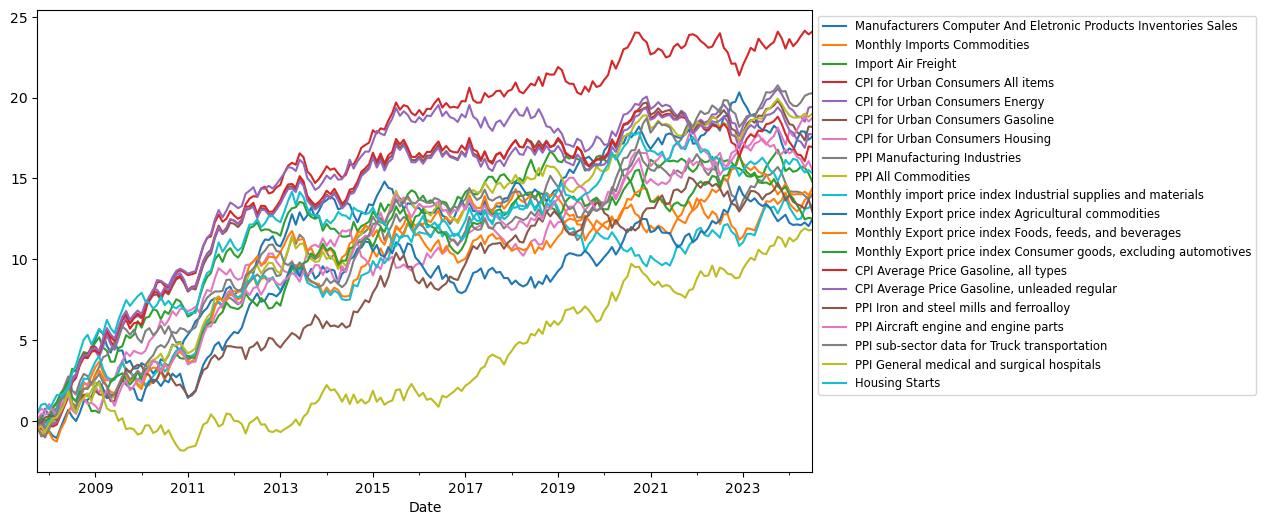

In [16]:
cumic(selected_features, ic_df)

In [17]:
ic_df[selected_features].corr()

,Manufacturers Computer And Eletronic Products Inventories Sales,Monthly Imports Commodities,Import Air Freight,CPI for Urban Consumers All items,CPI for Urban Consumers Energy,CPI for Urban Consumers Gasoline,CPI for Urban Consumers Housing,PPI Manufacturing Industries,PPI All Commodities,Monthly import price index Industrial supplies and materials,Monthly Export price index Agricultural commodities,"Monthly Export price index Foods, feeds, and beverages","Monthly Export price index Consumer goods, excluding automotives","CPI Average Price Gasoline, all types","CPI Average Price Gasoline, unleaded regular",PPI Iron and steel mills and ferroalloy,PPI Aircraft engine and engine parts,PPI sub-sector data for Truck transportation,PPI General medical and surgical hospitals,Housing Starts
Manufacturers Computer And Eletronic Products Inventories Sales,1.000000,0.094715,0.030704,0.060647,0.044017,0.010609,0.042655,0.053755,0.124545,0.076005,0.202867,0.210528,0.133436,0.016507,0.001884,-0.222519,-0.006157,0.093919,0.112654,0.045008
Monthly Imports Commodities,0.094715,1.000000,0.259214,0.441553,0.412831,0.475016,-0.001987,0.627126,0.563929,0.947183,0.172473,0.154100,0.239636,0.481356,0.471654,0.210841,0.284192,0.515743,0.225940,0.314260
Import Air Freight,0.030704,0.259214,1.000000,0.219563,0.227917,0.319544,-0.092940,0.178016,0.213308,0.321193,0.159252,0.198677,0.078050,0.313385,0.313352,0.247395,0.109001,0.294142,0.196858,0.171020
CPI for Urban Consumers All items,0.060647,0.441553,0.219563,1.000000,0.672021,0.710572,0.283511,0.586462,0.527048,0.386847,0.179140,0.249410,0.160464,0.728866,0.715060,0.207692,0.301312,0.432254,0.155120,0.317344
CPI for Urban Consumers Energy,0.044017,0.412831,0.227917,0.672021,1.000000,0.889049,0.125159,0.460091,0.546305,0.370459,0.166468,0.240133,0.246921,0.866804,0.880102,0.092182,0.230924,0.438417,-0.093983,0.172878
CPI for Urban Consumers Gasoline,0.010609,0.475016,0.319544,0.710572,0.889049,1.000000,0.016675,0.522563,0.498185,0.430871,0.200214,0.273915,0.252422,0.985916,0.992371,0.106182,0.312318,0.460475,-0.000883,0.237069
CPI for Urban Consumers Housing,0.042655,-0.001987,-0.092940,0.283511,0.125159,0.016675,1.000000,0.124589,0.271251,-0.048767,0.100156,0.063157,0.106234,0.016478,0.016033,0.082432,0.226298,0.037157,-0.030971,0.071977
PPI Manufacturing Industries,0.053755,0.627126,0.178016,0.586462,0.460091,0.522563,0.124589,1.000000,0.739684,0.558672,0.293196,0.261357,0.365342,0.536728,0.531529,0.346640,0.320416,0.553863,0.318586,0.367761
PPI All Commodities,0.124545,0.563929,0.213308,0.527048,0.546305,0.498185,0.271251,0.739684,1.000000,0.516356,0.501683,0.482488,0.364487,0.500032,0.498131,0.385389,0.323106,0.601583,0.214007,0.188993
Monthly import price index Industrial supplies and materials,0.076005,0.947183,0.321193,0.386847,0.370459,0.430871,-0.048767,0.558672,0.516356,1.000000,0.164978,0.154426,0.202087,0.430875,0.426116,0.223428,0.245862,0.477895,0.205077,0.289834


# Manage Multilinearity

In [18]:
def hot_corr(name,ic_df):

    ax = plt.subplots(figsize=(len(name), len(name)))
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.4, square=True, annot= True,cmap = 'Blues')
    plt.title('Factors_IC_CORRELATION')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

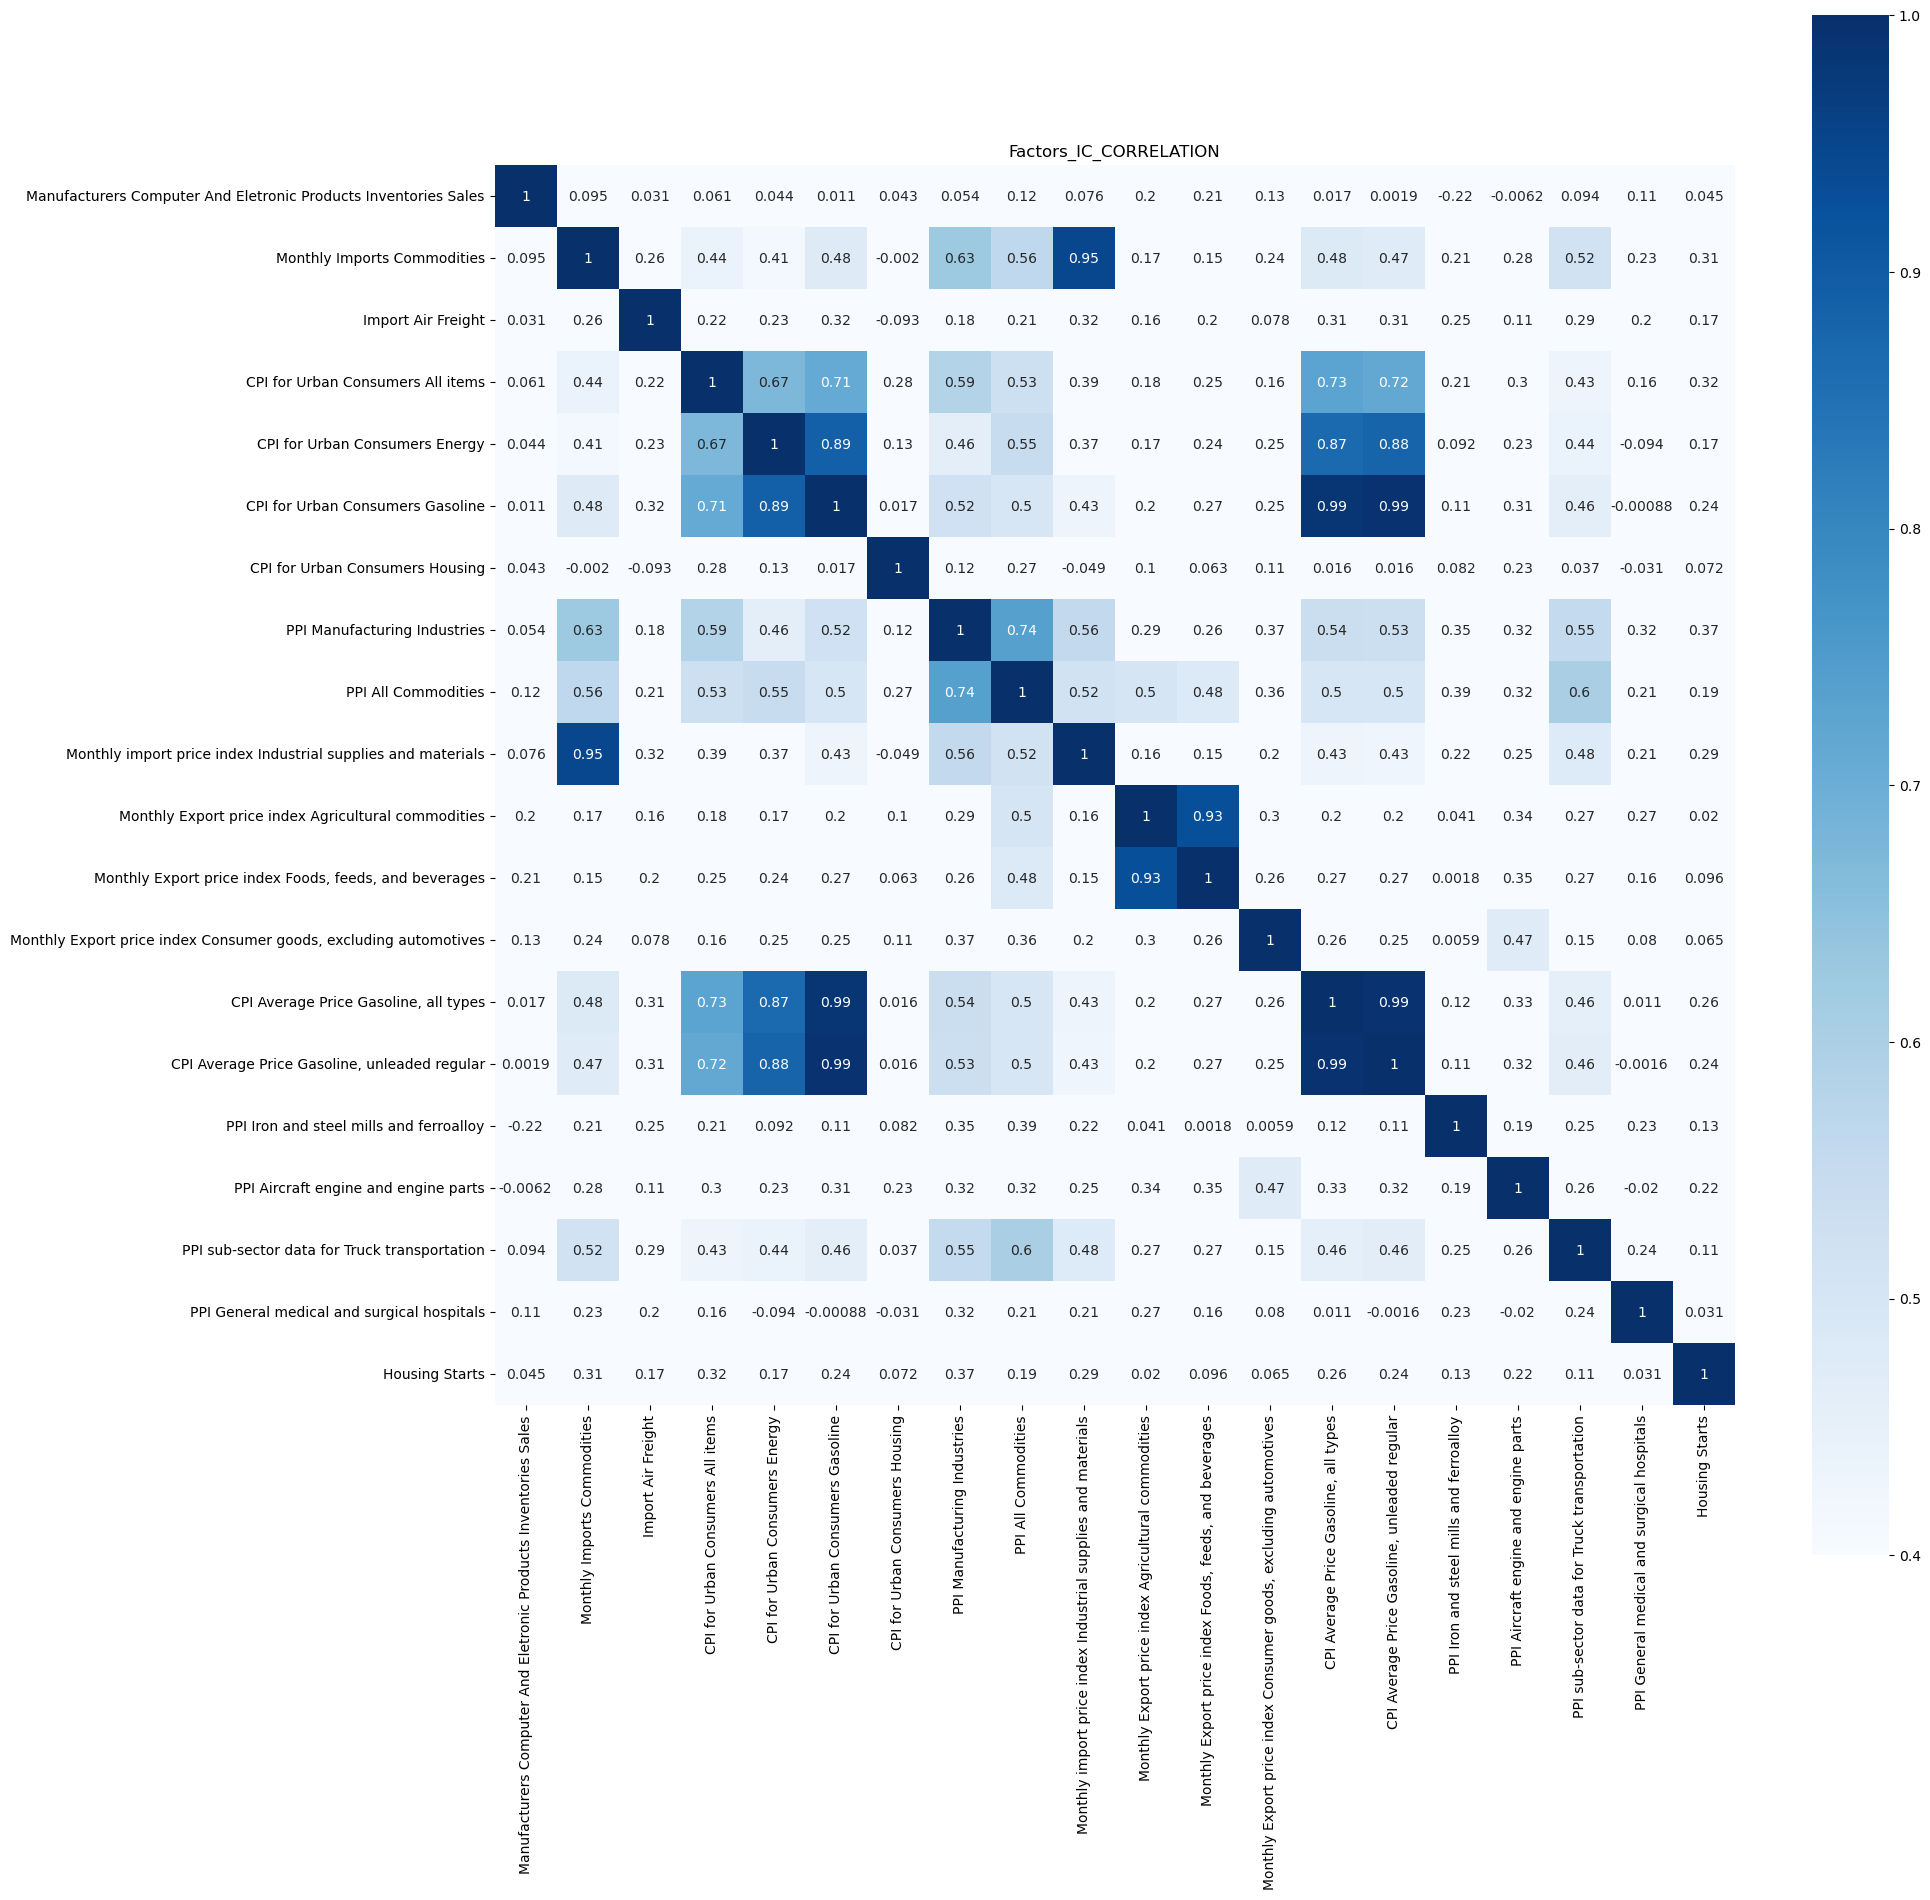

In [19]:
hot_corr(selected_features, ic_df)

In [20]:
# VIF
ic_df_pass = ic_df[selected_features]
VIF = {}
for i in ic_df_pass.columns.tolist():
    y = ic_df_pass[i]
    x = ic_df_pass.drop(i,axis = 1)
    VIF[i] = 1 / (1 - sm.OLS(y.astype(float),x.astype(float),hasconst=False, missing='drop').fit().rsquared)

VIF = pd.DataFrame([VIF]).T
VIF.columns = ['VIF']
VIF.sort_values(by = 'VIF',ascending=False)

,VIF
"CPI Average Price Gasoline, unleaded regular",123.994000
CPI for Urban Consumers Gasoline,80.468156
"CPI Average Price Gasoline, all types",70.890866
Monthly Imports Commodities,13.127681
Monthly import price index Industrial supplies and materials,11.415766
Monthly Export price index Agricultural commodities,10.537429
"Monthly Export price index Foods, feeds, and beverages",10.446204
CPI for Urban Consumers Energy,6.982507
PPI All Commodities,5.093277
PPI Manufacturing Industries,3.874755


In [21]:
def corr_line(ic_df,low = 0.8,high = 1):

    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [22]:
high_data = corr_line(ic_df[selected_features])
high_data

CORRELATION
factor_a                                           factor_b                                                       
Monthly Imports Commodities                        Monthly import price index Industrial supplies ...     0.947183
CPI for Urban Consumers Energy                     CPI for Urban Consumers Gasoline                       0.889049
                                                   CPI Average Price Gasoline, all types                  0.866804
                                                   CPI Average Price Gasoline, unleaded regular           0.880102
CPI for Urban Consumers Gasoline                   CPI Average Price Gasoline, all types                  0.985916
                                                   CPI Average Price Gasoline, unleaded regular           0.992371
Monthly Export price index Agricultural commodi... Monthly Export price index Foods, feeds, and be...     0.929304
CPI Average Price Gasoline, all types              CPI Average Price Gasoline, unleaded regular           0.991403

In [23]:
orth_wait = list(set(high_data.index.get_level_values(0)) | set(high_data.index.get_level_values(1)))
orth_wait

['Monthly Export price index Agricultural commodities',
 'CPI Average Price Gasoline, unleaded regular',
 'Monthly import price index Industrial supplies and materials',
 'Monthly Imports Commodities',
 'CPI for Urban Consumers Energy',
 'Monthly Export price index Foods, feeds, and beverages',
 'CPI for Urban Consumers Gasoline',
 'CPI Average Price Gasoline, all types']

In [24]:
corr_group = {0:['Monthly Imports Commodities','Monthly import price index Industrial supplies and materials'],
              1:['Monthly Export price index Agricultural commodities','Monthly Export price index Foods, feeds, and beverages'],
              2:['CPI for Urban Consumers Gasoline','CPI Average Price Gasoline, all types', 'CPI Average Price Gasoline, unleaded regular'],
              3:['CPI for Urban Consumers Energy','CPI for Urban Consumers Gasoline','CPI Average Price Gasoline, all types','CPI Average Price Gasoline, unleaded regular']}

In [25]:
for i in list(corr_group.keys()):
    del_factors = ic_summary.loc[corr_group[i],'IR'].sort_values(ascending = False).index.tolist()[1:]
    selected_features = [feature for feature in selected_features if feature not in del_factors]
selected_features

['Manufacturers Computer And Eletronic Products Inventories Sales',
 'Monthly Imports Commodities',
 'Import Air Freight',
 'CPI for Urban Consumers All items',
 'CPI for Urban Consumers Energy',
 'CPI for Urban Consumers Housing',
 'PPI Manufacturing Industries',
 'PPI All Commodities',
 'Monthly Export price index Foods, feeds, and beverages',
 'Monthly Export price index Consumer goods, excluding automotives',
 'PPI Iron and steel mills and ferroalloy',
 'PPI Aircraft engine and engine parts',
 'PPI sub-sector data for Truck transportation',
 'PPI General medical and surgical hospitals',
 'Housing Starts']

In [26]:
def corr_line(ic_df,low = 0.65,high = 1):
    
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [27]:
middle_data = corr_line(ic_df[selected_features])
middle_data

,,CORRELATION
factor_a,factor_b,
CPI for Urban Consumers All items,CPI for Urban Consumers Energy,0.672021
PPI Manufacturing Industries,PPI All Commodities,0.739684


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0, 0.5, 'CPI for Urban Consumers All items'),
  Text(0, 1.5, 'PPI All Commodities'),
  Text(0, 2.5, 'PPI Manufacturing Industries'),
  Text(0, 3.5, 'CPI for Urban Consumers Energy')])

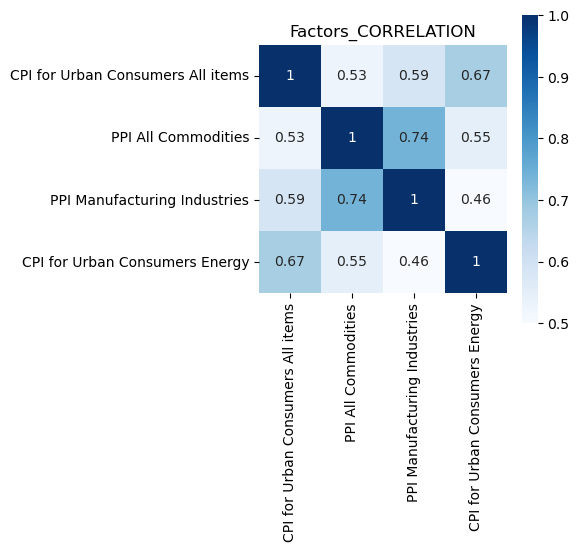

In [28]:
orth_wait = list(set(middle_data.index.get_level_values(0)) | set(middle_data.index.get_level_values(1)))
ax = plt.subplots(figsize=(len(orth_wait), len(orth_wait)))
ax = sns.heatmap(ic_df[orth_wait].corr(),vmin=0.5, square=True, annot= True,cmap = 'Blues')
plt.title('Factors_CORRELATION')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Selected Features

In [29]:
df[selected_features]

Manufacturers Computer And Eletronic Products Inventories Sales  \
Tickers Date                                                                          
XLB     2004-12-31                                              37751                 
        2005-01-31                                              39686                 
        2005-02-28                                              40342                 
        2005-03-31                                              38906                 
        2005-04-30                                              40114                 
...                                                               ...                 
XLY     2024-04-30                                              55263                 
        2024-05-31                                              55541                 
        2024-06-30                                              54591                 
        2024-07-31                                              55181                 
        2024-08-31                                              55301                 

                    Monthly Imports Commodities  Import Air Freight  \
Tickers Date                                                          
XLB     2004-12-31                        104.0               126.8   
        2005-01-31                        104.6               128.6   
        2005-02-28                        105.5               128.6   
        2005-03-31                        107.8               128.6   
        2005-04-30                        108.8               128.4   
...                                         ...                 ...   
XLY     2024-04-30                        141.7               232.6   
        2024-05-31                        141.5               231.0   
        2024-06-30                        141.6               232.6   
        2024-07-31                        141.8               264.3   
        2024-08-31                        141.4               271.0   

                    CPI for Urban Consumers All items  \
Tickers Date                                            
XLB     2004-12-31                              190.3   
        2005-01-31                              190.7   
        2005-02-28                              191.8   
        2005-03-31                              193.3   
        2005-04-30                              194.6   
...                                               ...   
XLY     2024-04-30                              313.5   
        2024-05-31                              314.1   
        2024-06-30                              314.2   
        2024-07-31                              314.5   
        2024-08-31                              314.8   

                    CPI for Urban Consumers Energy  \
Tickers Date                                         
XLB     2004-12-31                           153.7   
        2005-01-31                           151.9   
        2005-02-28                           155.2   
        2005-03-31                           160.8   
        2005-04-30                           170.9   
...                                            ...   
XLY     2024-04-30                           290.8   
        2024-05-31                           290.1   
        2024-06-30                           286.7   
        2024-07-31                           287.9   
        2024-08-31                           282.6   

                    CPI for Urban Consumers Housing  \
Tickers Date                                          
XLB     2004-12-31                            190.7   
        2005-01-31                            191.8   
        2005-02-28                            192.7   
        2005-03-31                            194.1   
        2005-04-30                            194.4   
...                                             ...   
XLY     2024-04-30                            331.7   
        2024-05-31      

# Genetic Programming

In [30]:
base_function = ['add', 'sub', 'mul', 'div','abs','neg','log']

window = 10

def _delta(data):
    value = np.diff(data.flatten())
    value = np.append(0, value)

    return value

def _sma(data):
    window=36
    value = np.array(pd.Series(data.flatten()).rolling(window).mean().tolist())
    value = np.nan_to_num(value)
    
    return value

def _stddev(data):
    window=36
    value = np.array(pd.Series(data.flatten()).rolling(window).std().tolist())
    value = np.nan_to_num(value)
    return value

stddev = make_function(function=_stddev, name='stddev', arity=1)
delta = make_function(function=_delta, name='delta', arity=1)
sma = make_function(function=_sma, name='sma', arity=1)

user_function = [stddev,delta,sma]

function_set = base_function + user_function

In [31]:
#gp_factor_train = rolling_exposure[selected_features]
#base_Factor = gp_factor_train.columns.tolist()
#gp_factor_train.head()

gp_factor_train = df[selected_features]
base_Factor = gp_factor_train.columns.tolist()
gp_factor_train.head()

Manufacturers Computer And Eletronic Products Inventories Sales  \
Tickers Date                                                                          
XLB     2004-12-31                                              37751                 
        2005-01-31                                              39686                 
        2005-02-28                                              40342                 
        2005-03-31                                              38906                 
        2005-04-30                                              40114                 

                    Monthly Imports Commodities  Import Air Freight  \
Tickers Date                                                          
XLB     2004-12-31                        104.0               126.8   
        2005-01-31                        104.6               128.6   
        2005-02-28                        105.5               128.6   
        2005-03-31                        107.8               128.6   
        2005-04-30                        108.8               128.4   

                    CPI for Urban Consumers All items  \
Tickers Date                                            
XLB     2004-12-31                              190.3   
        2005-01-31                              190.7   
        2005-02-28                              191.8   
        2005-03-31                              193.3   
        2005-04-30                              194.6   

                    CPI for Urban Consumers Energy  \
Tickers Date                                         
XLB     2004-12-31                           153.7   
        2005-01-31                           151.9   
        2005-02-28                           155.2   
        2005-03-31                           160.8   
        2005-04-30                           170.9   

                    CPI for Urban Consumers Housing  \
Tickers Date                                          
XLB     2004-12-31                            190.7   
        2005-01-31                            191.8   
        2005-02-28                            192.7   
        2005-03-31                            194.1   
        2005-04-30                            194.4   

                    PPI Manufacturing Industries  PPI All Commodities  \
Tickers Date                                                            
XLB     2004-12-31                         145.0                150.2   
        2005-01-31                         146.2                150.9   
        2005-02-28                         147.0                151.6   
        2005-03-31                         148.9                153.7   
        2005-04-30                         149.6                155.0   

                    Monthly Export price index Foods, feeds, and beverages  \
Tickers Date                                                                 
XLB     2004-12-31                                              116.9        
        2005-01-31                                              117.1        
        2005-02-28                                              116.4        
        2005-03-31                                              120.9        
        2005-04-30                                              121.0        

                    Monthly Export price index Consumer goods, excluding automotives  \
Tickers Date                                                                           
XLB     2004-12-31                                              101.2                  
        2005-01-31                                              101.7                  
        2005-02-28                                              101.6                  
        2005-03-31                                              101.6                  
        2005-04-30                                              101.9                  

                    PPI Iron and steel mills and ferroalloy  \
Tickers 

In [32]:
stock_list = gp_factor_train.index.get_level_values(0).tolist()

del_index = []
for i in range(1,len(stock_list)):
    if stock_list[i - 1] != stock_list[i]:
        del_index.append(i)

In [33]:
def _my_metric_group(y, y_pred, w):
    x1 = pd.Series(y.flatten())
    for i in del_index:
        try:
            y_pred[i:i+window*5] = np.nan           
        except:
            break
    
    x2 = pd.Series(y_pred.flatten())
  
    df = pd.concat([x1.to_frame('y'),
                    x2.to_frame('y_pred')],axis=1).dropna()

   
    df.sort_values(by = 'y_pred',ascending = True,inplace = True)
    
    gap = [int(i) for i in list(np.linspace(start = 0, stop = len(df), num = 11))]
    y_1 = df["y"][0:gap[1]].mean()
    y_2 = df["y"][gap[1]:gap[2]].mean()
    y_3 = df["y"][gap[2]:gap[3]].mean()
    y_4 = df["y"][gap[3]:gap[4]].mean()
    y_5 = df["y"][gap[4]:gap[5]].mean()
    y_6 = df["y"][gap[5]:gap[6]].mean()
    y_7 = df["y"][gap[6]:gap[7]].mean()
    y_8 = df["y"][gap[7]:gap[8]].mean()
    y_9 = df["y"][gap[8]:gap[9]].mean()
    y_10 = df["y"][gap[9]:].mean()
   
    value = (np.corrcoef(np.array([y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10]).argsort(),
                         (np.arange(1,11)))[0,1])
    
    return value

my_metric_group = make_fitness(function=_my_metric_group, greater_is_better=True)

In [34]:
gp_factor_train[base_Factor].index

MultiIndex([('XLB', '2004-12-31'),
            ('XLB', '2005-01-31'),
            ('XLB', '2005-02-28'),
            ('XLB', '2005-03-31'),
            ('XLB', '2005-04-30'),
            ('XLB', '2005-05-31'),
            ('XLB', '2005-06-30'),
            ('XLB', '2005-07-31'),
            ('XLB', '2005-08-31'),
            ('XLB', '2005-09-30'),
            ...
            ('XLY', '2023-11-30'),
            ('XLY', '2023-12-31'),
            ('XLY', '2024-01-31'),
            ('XLY', '2024-02-29'),
            ('XLY', '2024-03-31'),
            ('XLY', '2024-04-30'),
            ('XLY', '2024-05-31'),
            ('XLY', '2024-06-30'),
            ('XLY', '2024-07-31'),
            ('XLY', '2024-08-31')],
           names=['Tickers', 'Date'], length=2323)

In [35]:
X_train = np.nan_to_num(gp_factor_train[base_Factor].values)
y_train = np.nan_to_num(df.loc[gp_factor_train[base_Factor].index]['Return'])

metric_type = 'my_metric_group'
version = 'v3'

generations = 3
population_size = 10000
random_state = 0

est_gp = SymbolicTransformer(feature_names = base_Factor,                     
                            function_set = function_set,                     
                            stopping_criteria = 0.03,                         
                            metric = my_metric_group,                         
                            generations = generations,                        
                            population_size = population_size,                
                            tournament_size = 50,                             
                            init_depth = (2,2),                               
                            random_state = random_state,                      
                            n_components = 20,                                
                            const_range = (-1,1),                             
                            n_jobs = -1                                    
                         )


est_gp.fit(X_train, y_train)

best_programs = est_gp._best_programs
best_programs_dict = {}

for p in best_programs:
    factor_name = 'Macro_Factors' + str(best_programs.index(p) + 1)
    best_programs_dict[factor_name] = {'fitness':p.fitness_, 'expression':str(p), 'depth':p.depth_, 'length':p.length_}

best_programs_dict = pd.DataFrame(best_programs_dict).T
best_programs_dict = best_programs_dict[best_programs_dict.fitness.abs() >= 0.2]
best_programs_dict = best_programs_dict.sort_values(by= 'fitness',ascending=False)
best_programs_dict

,fitness,expression,depth,length
Macro_Factors1,0.763697,"add(delta(Housing Starts), add(0.892, Monthly ...",2,6
Macro_Factors2,0.728333,"sub(delta(Monthly Imports Commodities), log(Im...",2,5
Macro_Factors3,0.717212,"delta(sub(PPI Manufacturing Industries, PPI su...",2,4
Macro_Factors4,0.717212,"delta(sub(Monthly Imports Commodities, PPI Air...",2,4
Macro_Factors5,0.666727,"div(stddev(Import Air Freight), mul(Monthly Im...",2,6
Macro_Factors6,0.644485,"delta(mul(Monthly Imports Commodities, Import ...",2,4
Macro_Factors8,0.643485,"div(delta(CPI for Urban Consumers Energy), sma...",2,5
Macro_Factors7,0.642485,div(abs(PPI General medical and surgical hospi...,2,6
Macro_Factors9,0.633364,delta(delta(Monthly Export price index Consume...,2,3
Macro_Factors10,0.631364,"div(delta(Import Air Freight), delta(PPI Aircr...",2,5


In [36]:
import graphviz
def alpha_factor_graph(num):

    factor = best_programs[num-1]
    print(factor)
    print('fitness: {0}, depth: {1}, length: {2}'.format(factor.fitness_, factor.depth_, factor.length_))

    dot_data = factor.export_graphviz()
    graph = graphviz.Source(dot_data)
    graph.render('images/alpha_factor_graph', format='png', cleanup=True)
    
    return graph

div(delta(Import Air Freight), delta(PPI Aircraft engine and engine parts))
fitness: 0.6313636363636362, depth: 2, length: 5


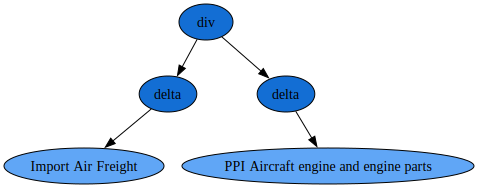

In [51]:
alpha_factor_graph(10)

In [38]:
def macro_factor_10(df):
    value1 = df['Import Air Freight'].pct_change()
    value2 = df['PPI Aircraft engine and engine parts'].pct_change()
    value = value1/value2
    
    return value.unstack('Tickers')

In [39]:
macro_10 = macro_factor_10(df)

In [40]:
def exposure_return_IC(exposures, returns, index_item, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)
    
    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    
    return result,report
                                                                        
                           

In [41]:
def Rank_IC(exposures, returns, name=''):
    result = exposures.corrwith(returns, axis=1, method='spearman').dropna(how='all')
    t_stat, _ = stats.ttest_1samp(result, 0)

    report = {'name': name,
    'IC mean':round(result.mean(),4),
    'IC std':round(result.std(),4),
    'IR':round(result.mean()/result.std(),4),
    'IC>0':round(len(result[result>0].dropna())/len(result),4),
    'ABS_IC>2%':round(len(result[abs(result) > 0.02].dropna())/len(result),4),
    't_stat':round(t_stat,4),
    }

    report = pd.DataFrame([report])
    print(report)
    return result,report

In [42]:
returns

Tickers,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2004-11-30,NaN,NaN,-0.753503,-0.824147,-0.546193,-0.878577,-0.939393,NaN,-0.684162,-0.729480,-0.832333
2004-12-31,0.013158,NaN,-0.028425,0.041457,0.024662,0.025770,0.037509,NaN,0.024890,0.055122,0.046839
2005-01-31,-0.030649,NaN,0.034053,-0.021713,-0.027843,-0.056373,0.011569,NaN,0.021429,-0.031438,-0.042925
2005-02-28,0.078778,NaN,0.167904,-0.006782,0.011650,0.001948,-0.000715,NaN,0.020979,0.030072,-0.005321
2005-03-31,-0.026329,NaN,-0.019460,-0.037865,-0.000480,-0.019443,-0.009299,NaN,0.010959,-0.005561,-0.011464
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.045850,-0.046552,-0.009366,-0.041627,-0.035246,-0.057582,-0.011275,-0.084406,0.016540,-0.050133,-0.044998
2024-05-31,0.032680,0.069362,-0.003478,0.031702,0.016403,0.070764,0.024282,0.051433,0.089568,0.024056,0.002001
2024-06-30,-0.030544,0.031526,-0.014177,-0.008952,-0.009862,0.078312,-0.002227,0.019513,-0.055408,0.018232,0.038749


In [43]:
m10_ic, m10_df = Rank_IC(macro_10, returns, 'macro_10')

       name  IC mean  IC std      IR  IC>0  ABS_IC>2%  t_stat
0  macro_10   0.0111  0.7228  0.0154   0.5        1.0  0.0217


/Users/berry-li/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [44]:
macro_10

Tickers,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2004-11-30,NaN,NaN,1.319791,1.319791,1.319791,1.319791,1.319791,NaN,1.319791,1.319791,1.319791
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-31,1.435528,NaN,1.435528,1.435528,1.435528,1.435528,1.435528,NaN,1.435528,1.435528,1.435528
2005-02-28,-0.000000,NaN,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,NaN,-0.000000,-0.000000,-0.000000
2005-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,75.740236,75.740236,75.740236,75.740236,75.740236,75.740236,75.740236,75.740236,75.740236,75.740236,75.740236
2024-05-31,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813,-9.258813
2024-06-30,3.731948,3.731948,3.731948,3.731948,3.731948,3.731948,3.731948,3.731948,3.731948,3.731948,3.731948


sub(delta(Monthly Imports Commodities), log(Import Air Freight))
fitness: 0.7283333333333332, depth: 2, length: 5


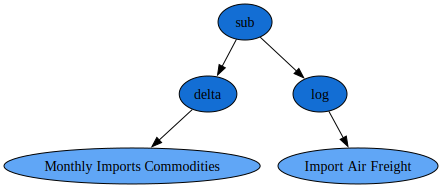

In [45]:
alpha_factor_graph(2)

In [46]:
def macro_factor_2(df):
    value1 = df['Monthly Imports Commodities'].pct_change()
    value = value1 - np.log(df['Import Air Freight'])
    
    return value.unstack('Tickers')

      name  IC mean  IC std       IR  IC>0  ABS_IC>2%   t_stat
0  macro_2   0.5111  0.0157  32.5115   1.0        1.0  45.9783


/Users/berry-li/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


<Axes: xlabel='Date'>

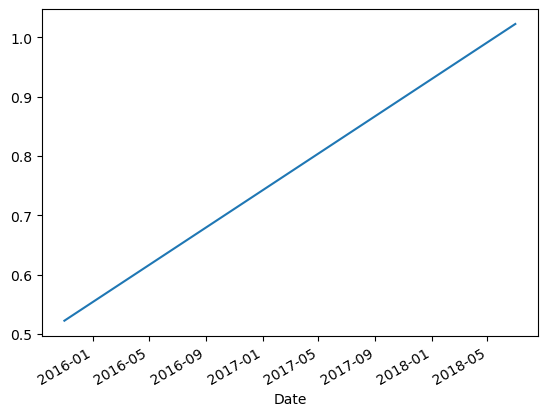

In [47]:
macro_2 = macro_factor_2(df)
m2_ic, m2_df = Rank_IC(macro_2, returns, 'macro_2')
m2_ic.sort_index().cumsum().plot()

In [48]:
macro_2.head()

Tickers,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
Date,,,,,,,,,,,
2004-11-30,NaN,NaN,-5.096501,-5.096501,-5.096501,-5.096501,-5.096501,NaN,-5.096501,-5.096501,-5.096501
2004-12-31,NaN,NaN,-4.856829,-4.856829,-4.856829,-4.856829,-4.856829,NaN,-4.856829,-4.856829,-4.856829
2005-01-31,-4.850938,NaN,-4.850938,-4.850938,-4.850938,-4.850938,-4.850938,NaN,-4.850938,-4.850938,-4.850938
2005-02-28,-4.848103,NaN,-4.848103,-4.848103,-4.848103,-4.848103,-4.848103,NaN,-4.848103,-4.848103,-4.848103
2005-03-31,-4.834906,NaN,-4.834906,-4.834906,-4.834906,-4.834906,-4.834906,NaN,-4.834906,-4.834906,-4.834906


In [49]:
df

Price  Business Applications  Construction Spending  \
Tickers Date                                                               
XLB     2004-12-31   19.25                 193328                1037480   
        2005-01-31   18.66                 201725                1046082   
        2005-02-28   20.13                 204234                1066848   
        2005-03-31   19.60                 201630                1071745   
        2005-04-30   18.20                 204096                1081012   
...                    ...                    ...                    ...   
XLY     2024-04-30  174.88                 430762                2163179   
        2024-05-31  175.23                 423211                2168211   
        2024-06-30  182.02                 430692                2168990   
        2024-07-31  187.10                 421534                2162683   
        2024-08-31  186.73                 431928                2162683   

                    Durable Goods New Orders  International Trade_Exports  \
Tickers Date                                                                
XLB     2004-12-31                    193578                       102781   
        2005-01-31                    194875                       103206   
        2005-02-28                    196475                       104010   
        2005-03-31                    186608                       105098   
        2005-04-30                    194847                       107268   
...                                      ...                          ...   
XLY     2024-04-30                    282737                       262314   
        2024-05-31                    282987                       260790   
        2024-06-30                    263541                       265266   
        2024-07-31                    289587                       266603   
        2024-08-31                    289720                       266603   

                    International Trade_Imports  Manu Inventories  \
Tickers Date                                                        
XLB     2004-12-31                       157699            441222   
        2005-01-31                       159395            446240   
        2005-02-28                       162104            451361   
        2005-03-31                       158231            455394   
        2005-04-30                       164580            456990   
...                                         ...               ...   
XLY     2024-04-30                       337217            858304   
        2024-05-31                       336096            859416   
        2024-06-30                       338282            858851   
        2024-07-31                       345394            859422   
        2024-08-31                       345394            859422   

                    Manu New Orders  New Homes For Sale  New Homes Sold  ...  \
Tickers Date                                                             ...   
XLB     2004-12-31           373419                 422            1242  ...   
        2005-01-31           378937                 441            1203  ...   
        2005-02-28           381880                 446            1319  ...   
        2005-03-31           374642                 445            1328  ...   
        2005-04-30           385450                 445            1260  ...   
...                             ...                 ...             ...  ...   
XLY     2024-04-30           586114                 464             736  ...   
        2024-05-31           583300                 468             672  ...   
        2024-06-30           563972                 468             681  ...   
        2024-07-31           592140                 459             751  ...   
        2024-08-31           592140                 467             716  ...   

                    Monetary Base       M2  Unemp_Rate  Auto Sales  \
Tickers Date         

In [50]:
macro_2_df = macro_2.reset_index().melt(id_vars=['Date'], value_vars=tickers, var_name='Tickers', value_name='macro 2').set_index(['Tickers','Date'])
macro_2_df.to_csv('macro_2.csv')